# Novelty Detection with an Autoencoder

***

## Contents
1. [Overview](#1)
2. [Data](#2)
3. [Autoencoder](#3)
4. [Optimizing Fraud Costs](#4)
5. [Conclusion](#5)

***
## 1. Overview
<a id = '1'></a>
In this notebook we will be using an autoencoder on the fraud dataset used in a [previous notebook](https://github.com/wenhao7/Data-Science/blob/main/Credit%20Card%20Fraud%20Detection/Credit%20Card%20Fraud%20Detection.ipynb) for novelty detection. Novelty detection refers to the identification of new or unknown signals not available to a machine learning system during training. In this case it refers to training a machine learning model only on normal(non-fradulent) transactions data but the resultant model has the ability to recognise fraudulent transactions.

***
<a id = '2'></a>
## 2. Data
Data used in this notebook can be found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud). Exploration and discussion of the data has previously been conducted in the [previous notebook](https://github.com/wenhao7/Data-Science/blob/main/Credit%20Card%20Fraud%20Detection/Credit%20Card%20Fraud%20Detection.ipynb) so this notebook will mainly focus on training an autoencoder.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import Normalizer, RobustScaler
from scipy import stats
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

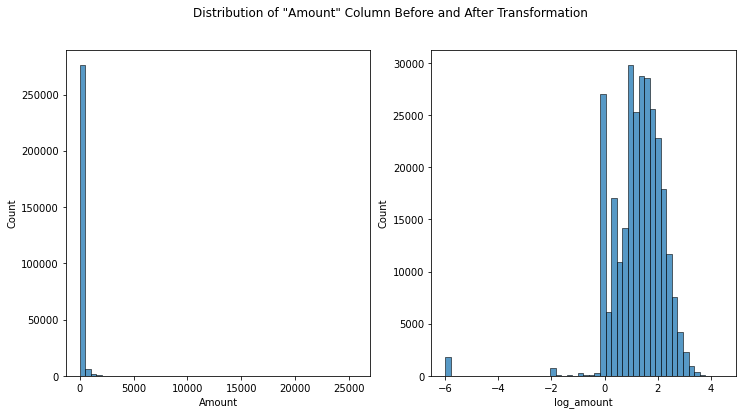

In [2]:
# Import Data
df = pd.read_csv('creditcard.csv')

# Transform 'Amount' column with log to make column closer to normal distribution
df['log_amount'] = np.log10(df.Amount + 0.000001)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
sns.histplot(bins = 50, x = 'Amount', data = df, ax = ax1)
sns.histplot(bins = 50, x = 'log_amount', data = df, ax = ax2)
fig.suptitle('Distribution of "Amount" Column Before and After Transformation')
plt.show()

In [3]:
# encode time feature
df['time_sine'] = np.sin(2*np.pi*df.Time / (24*60*60))
df['time_cosine'] = np.cos(2*np.pi*df.Time / (24*60*60))

df.drop('Amount', axis = 1, inplace = True)
df.drop('Time', axis = 1, inplace = True)

features = df.drop('Class', axis = 1)
label = df.Class

Transforming the data by taking its logarithm is an alternative to clipping the extreme outlier values. Taking the sine and cosine of time feature allows us to encode cyclical features such as time.

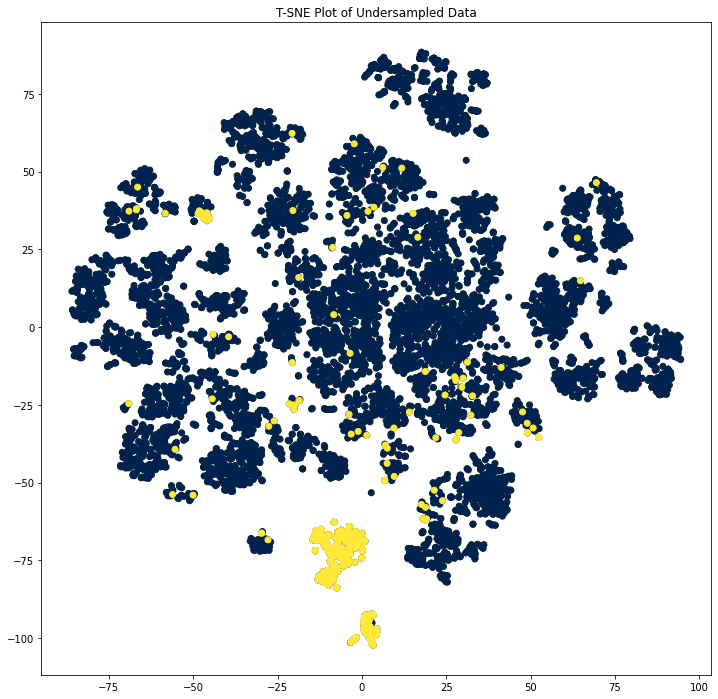

In [4]:
# T-SNE plot, undersampled for computation time considerations
undersampler = RandomUnderSampler(0.05)
X_under, y_under = undersampler.fit_resample(features, label)

X_tsne = TSNE(n_components = 2, random_state = 33).fit_transform(X_under.values)

fig, ax = plt.subplots(figsize = (12,12))
ax.set_title('T-SNE Plot of Undersampled Data')
ax.scatter(X_tsne[:,0], X_tsne[:,1], c = (y_under == 0), cmap ='cividis', label = 'Not Fraud')
ax.scatter(X_tsne[:,0], X_tsne[:,1], c = (y_under == 1), cmap ='cividis', label = 'Fraud') 

Looking at the TSNE plot we observe that a cluster of fraudulent transactions appear separable from the normal transactions, but a minority of fraud is still hidden within the normal clusters.

In [5]:
# Novelty Detection, only training on normal transactions

# (Train+Validation) and Test split
X_train = df.loc[df.Class == 0].sample(frac = 0.8, random_state = 33)
X_train.drop('Class', axis =1, inplace = True)

X_test = df.drop(X_train.index)

# Train and Validation split
X_train, X_valid = train_test_split(X_train, test_size = 0.25, random_state = 33)

# Test set
X_test, y_test = X_test.drop('Class', axis = 1).values, X_test.Class.values

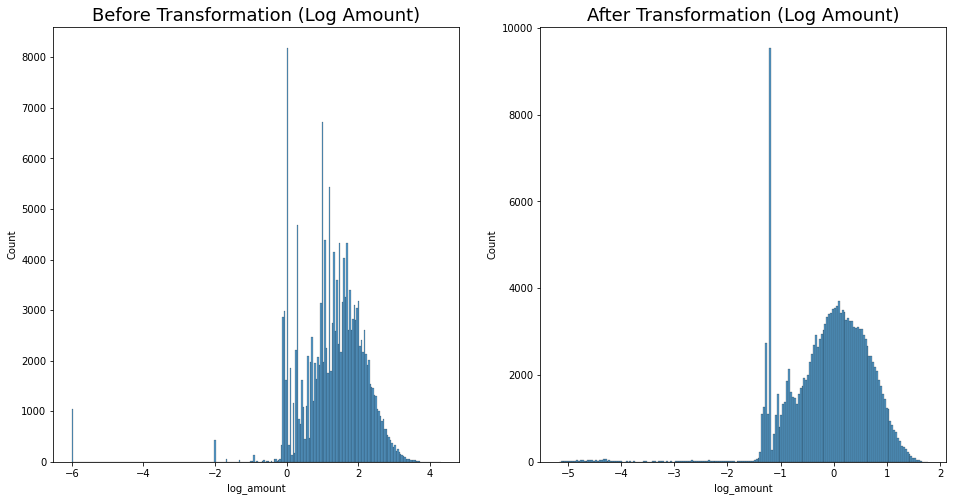

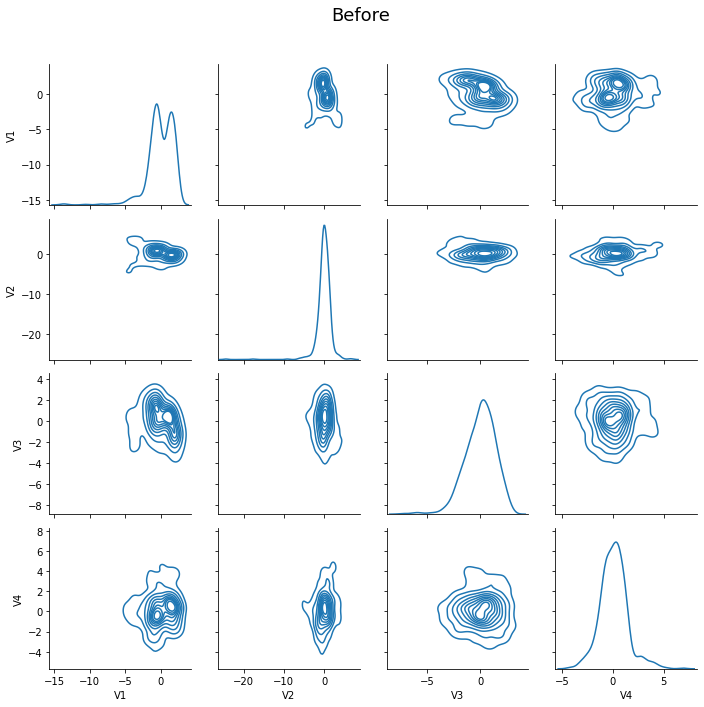

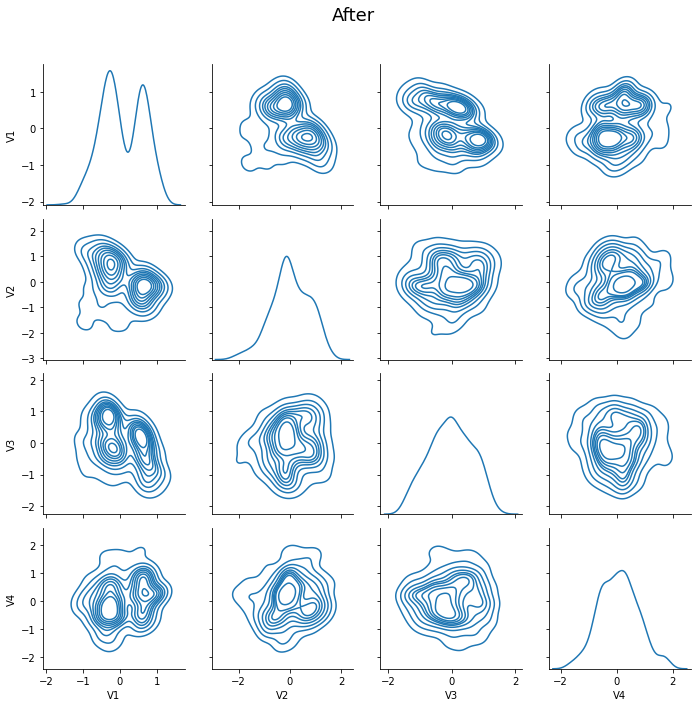

In [6]:
# Normalizer, Robust scaler
normalizer = Normalizer()
rob_scaler = RobustScaler()

# Transformations pipeline
pipeline = Pipeline([('normalizer', normalizer),
                     ('scaler', rob_scaler)])
pipeline.fit(X_train)

# Transform
X_train_scaled = pipeline.transform(X_train)
X_valid_scaled = pipeline.transform(X_valid)

df1 = pd.DataFrame(data = X_train_scaled, columns = X_train.columns)
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,8))
ax1.set_title('Before Transformation (Log Amount)', fontsize = 18)
sns.histplot(x = 'log_amount', data = X_train, ax = ax1)
ax2.set_title('After Transformation (Log Amount)', fontsize = 18)
sns.histplot(x = 'log_amount', data = df1, ax = ax2)
plt.show()
                   
# PairGrid first few features
g = sns.PairGrid(X_train.iloc[:,:4].sample(600, random_state = 33))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before', fontsize = 18)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot)        


g = sns.PairGrid(df1.iloc[:,:4].sample(600, random_state = 33))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After', fontsize = 18)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot)   

The above plots show how the normalizer and robust scaler helps make distribution of the data more uniform.

***
<a id = '3'></a>
## 3. Autoencoders
Autoencoders are a type of artificial neural network that learns a representation for a set of data. In this case we will teach an autoencoder to detect fraudulent transactions that are form signals that differs from normal transactions. The neural network contains an encoder and a decoder. In the encoder the amount of information that can flow through the network is limited by passing the input signals to a bottleneck with a constrained number of neurons. From this encoded state, the decoder will then learn how to best reconstruct the original input from the most important attributes of the input data.

In [7]:
# AutoEncoder
class AutoEncoder(Model):
  def __init__(self, output_units, code_size=2):
    super().__init__()
    
    self.encoder = Sequential([
      Dense(output_units, activation='elu'),
      #Dropout(0.1),
      Dense(16, activation='elu'),
      #Dropout(0.1),
      Dense(8, activation='elu'),
      #Dropout(0.1),
      Dense(4, activation='elu'),
      #Dropout(0.1),
      Dense(code_size, activation='elu')
    ])
    
    self.decoder = Sequential([
      Dense(4, activation='elu'),
      #Dropout(0.1),
      Dense(8, activation='elu'),
      #Dropout(0.1),
      Dense(16, activation='elu'),
      #Dropout(0.1),
      Dense(output_units, activation='elu')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
 
# Configurations of model 
model = AutoEncoder(output_units= X_train_scaled.shape[1])
model.compile(loss='mse', metrics=['acc'], optimizer='adam')

# Fit Model
history = model.fit(
    X_train_scaled,
    X_train_scaled,
    shuffle = True,
    epochs=30,
    batch_size=256,
    validation_data=(X_valid_scaled, X_valid_scaled)
)


Epoch 1/30
667/667 [==============================] - 6s 7ms/step - loss: 0.6010 - acc: 0.1943 - val_loss: 0.5613 - val_acc: 0.2609
Epoch 2/30
667/667 [==============================] - 5s 7ms/step - loss: 0.5528 - acc: 0.2544 - val_loss: 0.5448 - val_acc: 0.2602
Epoch 3/30
667/667 [==============================] - 5s 7ms/step - loss: 0.5381 - acc: 0.2790 - val_loss: 0.5299 - val_acc: 0.2883
Epoch 4/30
667/667 [==============================] - 5s 7ms/step - loss: 0.5213 - acc: 0.2926 - val_loss: 0.5145 - val_acc: 0.2954
Epoch 5/30
667/667 [==============================] - 4s 7ms/step - loss: 0.5101 - acc: 0.2978 - val_loss: 0.5066 - val_acc: 0.3002
Epoch 6/30
667/667 [==============================] - 5s 7ms/step - loss: 0.5034 - acc: 0.3083 - val_loss: 0.5005 - val_acc: 0.3131
Epoch 7/30
667/667 [==============================] - 5s 7ms/step - loss: 0.4976 - acc: 0.3225 - val_loss: 0.4955 - val_acc: 0.3353
Epoch 8/30
667/667 [==============================] - 4s 7ms/step - loss: 0.

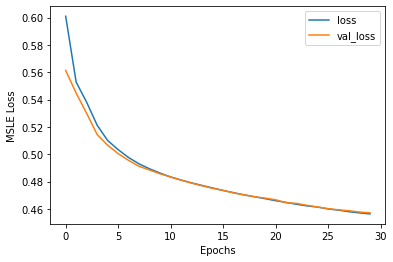

In [8]:
# Plot History
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

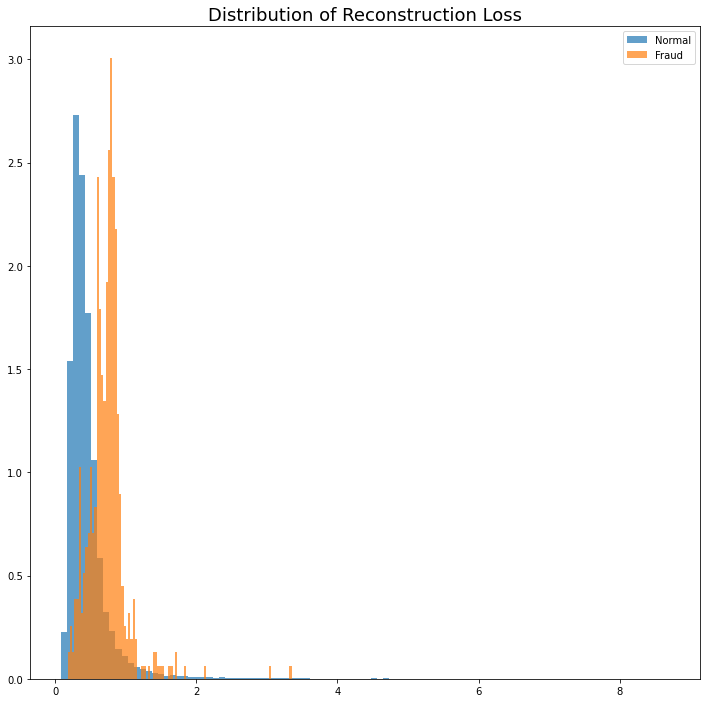

In [9]:
# Reconstructions - Test set
X_test_scaled= pipeline.transform(X_test)
reconstructions = model.predict(X_test_scaled)

# Calculating Mean Squared Error
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

# Plotting distribution of reconstruction loss
normal = mse[y_test == 0]
fraud = mse[y_test == 1]

fix, ax = plt.subplots(figsize = (12,12))
plt.title('Distribution of Reconstruction Loss', fontsize = 18)
ax.hist(normal ,bins = 100, density = True, label = 'Normal', alpha = 0.7)
ax.hist(fraud ,bins = 100, density = True, label = 'Fraud', alpha = 0.7)
plt.legend()
plt.show()

Looking at the reconstruction loss on the test set, we can see that that autoencoder recognises that fraudulent transactions are mostly distinct from normal one.s

In [10]:
# Threshold for classification

# Modified Z-score with Median Absolute Deviation
def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    
    mad = np.median(ad)
    
    return 0.6745*ad / mad # 0.6745 is the 75th percentile of normal dist

# Setting threshold to 2 arbitrarily
scores = mad_score(mse)
outliers = scores > 2

cm = confusion_matrix(y_test, outliers)
print('Confusion Matrix : \n', cm)

Confusion Matrix : 
 [[51055  5808]
 [  205   287]]


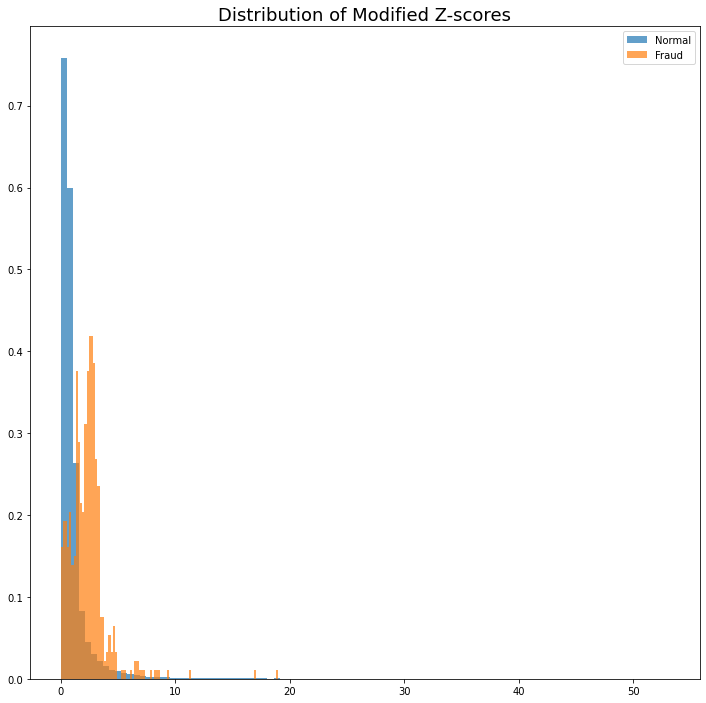

In [11]:
# Plot Distribution of Modified Z-scores
normal = scores[y_test == 0]
fraud = scores[y_test == 1]

fix, ax = plt.subplots(figsize = (12,12))
plt.title('Distribution of Modified Z-scores', fontsize = 18)
ax.hist(normal ,bins = 100, density = True, label = 'Normal', alpha = 0.7)
ax.hist(fraud ,bins = 100, density = True, label = 'Fraud', alpha = 0.7)
plt.legend()
plt.show()

Using a Modified Z-Scores based on the Median Absolute Deviation, we end up with scores that are more robust to outlier values in the data. In this particular case, the Modified Z-Scores will be used as the cut off thresholds to determine whether a particular transaction is classified as fraudulent or not.

Looking at the above plot, it appears that normal and fraudulent transactions have some overlaps which may results in poorer model performance.

***

<a id = '4'></a>
# 4. Optimizing Fraud Costs
When determining the threshold to use, one has to consider the costs of incorrect predictions namely False Positives (Type 1 Error) vs False Negatives (Type 2 Errors). For this example we will make a few assumptions:

False Positive:
- Cost of employee verifying transactions
    - Employee is paid 48000 euros annually, working 52 weeks and 40 hours work week
- Employee can verify transactions every 5 minutes

False Negative: 
- Cost of reimbursement

In reality many other factors will need to be considered, not limited to reputation damages, customer churn, etc.

In [12]:
# Cost of fraud
data = pd.read_csv('creditcard.csv')
avg_fraud = np.mean(data.loc[data.Class == 1].Amount.values)

# Cost of doing nothing
print("Cost per day of not doing anything : ", len(data[data.Class == 1])*avg_fraud/2)


# Cost of monitoring assuming its takes a worker 5mins to verify a flagged transaction
# Assuming 4000 monthly wage, 52 weeks, 40hr/week
avg_monitoring = (48000/(52*40))/(60/5)

# Ratio of costs type1:type2, avg_monitoring:avg_fraud
print("Ratio of costs for Type 1 vs Type 2 Errors :", avg_fraud/avg_monitoring)

Cost per day of not doing anything :  30063.985
Ratio of costs for Type 1 vs Type 2 Errors : 63.54988699186992


If nothing is done to catch the fraudulent transactions, it will cost approximately 30000 euros per day on average to reimburse the fraudulent transactions.

When comparing false positives and false negatives, the cost of an undetected fraudulent transaction is approximately 63x the cost of verifying a wrongly flagged normal transaction.

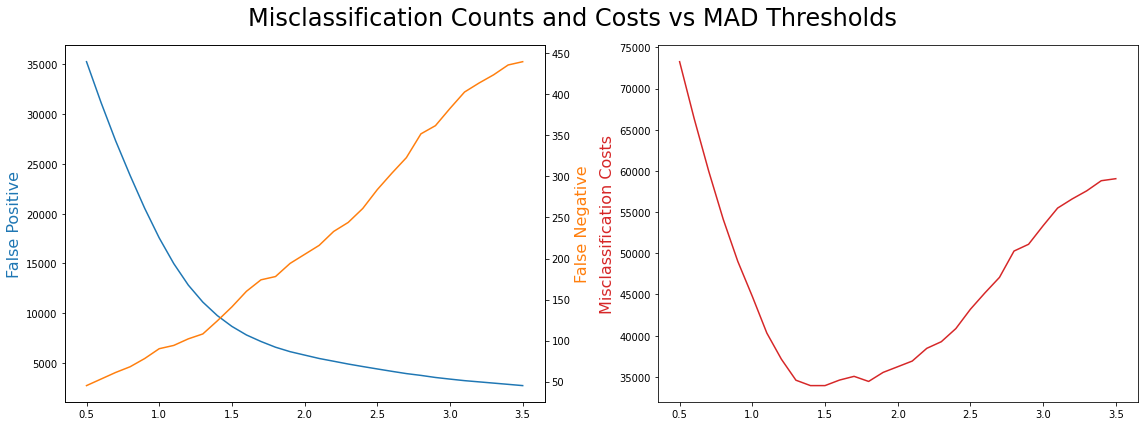

In [13]:
# Plot thresholds and their costs
false_neg = []
false_pos = []
costs = []
thresholds = np.arange(0.5, 3.6, 0.1)
for i in thresholds:
    outliers = scores > i
    cm = confusion_matrix(y_test, outliers)
    fn, fp = cm[1,0], cm[0,1]
    false_neg.append(fn)
    false_pos.append(fp)
    cost = (fn*avg_fraud) + (fp*avg_monitoring)
    costs.append(cost)
    
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Misclassification Counts and Costs vs MAD Thresholds', fontsize = 24)
ax3 = ax1.twinx()
ax1.plot(thresholds, false_pos, label = 'False Positive', color = 'tab:blue')
ax3.plot(thresholds, false_neg, label = 'False Negative', color = 'tab:orange')
ax1.set_ylabel('False Positive', fontsize = 16, color = 'tab:blue')
ax3.set_ylabel('False Negative', fontsize = 16, color = 'tab:orange')
ax2.plot(thresholds, costs, label = 'Misclassification Costs', color = 'tab:red')
ax2.set_ylabel('Misclassification Costs', fontsize = 16, color = 'tab:red')
fig.tight_layout()
plt.show()

Looking at the misclassification rates and costs across the thresholds, it seems that the optimal threshold that would result in the most cost savings is approximately 1.4.

In [14]:
# Min costs threshold
optimal_threshold = round(thresholds[costs.index(min(costs))],1)

outliers =  scores > optimal_threshold

print("Optimal Threshold Found : ", optimal_threshold)
print("Confusion Matrix :\n", confusion_matrix(y_test, outliers))
print("Cost per day at the optimal threshold : ", (min(costs)/2))
print("Optimal Cost-Savings : {}%".format(round(((len(data[data.Class == 1])*avg_fraud/2) - (min(costs)/2))/(len(data[data.Class == 1])*avg_fraud/2)*100, 2)))


Optimal Threshold Found :  1.4
Confusion Matrix :
 [[47099  9764]
 [  124   368]]
Cost per day at the optimal threshold :  16965.563449030644
Optimal Cost-Savings : 43.57%


With the simplistics and naive assumptions made above the optimal threshold is found to be 1.4.

At a threshold of 1.4 when compared to not doing anything to combat fraud the company can expect approximately 43% cost savings per day, spending only ~17000 euros compared to the ~30000 when nothing is done.

***

<a id = '5'></a>
## 5. Conclusion
In this notebook we have explored how an autoencoder can be used in anomaly detection, and the considerations when tuning a model to detect fraudulent transactions.